In [101]:
import pandas as pd


data_path = "/content/bank-full.csv"

df = pd.read_csv(data_path)

Подготовка данных

In [ ]:
df_split = df['age;"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"'].str.split(';', expand=True)

df_split.columns = ["age","job","marital","education","default","balance","housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome","y"]

df_split = df_split.drop(["default","loan"], axis=1)

df_split["y"] = df_split["y"].replace({'"yes"':1, '"no"':0})

df_split[df_split.select_dtypes(include=['object']).columns] = df_split.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')

Столбцы с числовыми данными

In [114]:
df_clean = df_split.dropna(axis=1)

In [115]:
df_clean

,age,balance,day,duration,campaign,pdays,previous,y
0,58,2143,5,261,1,-1,0,0
1,44,29,5,151,1,-1,0,0
2,33,2,5,76,1,-1,0,0
3,47,1506,5,92,1,-1,0,0
4,33,1,5,198,1,-1,0,0
...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,1
45207,71,1729,17,456,2,-1,0,1
45208,72,5715,17,1127,5,184,3,1
45209,57,668,17,508,4,-1,0,0


Разбиваем на тренировочную, валидационную и тестирующую выборки.

In [110]:
from sklearn.model_selection import train_test_split

y = df_clean['y']
X = df_clean.drop(columns=['y'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

Обучаем модель линейной регрессии и рассчитываем auc для каждого столбца

In [111]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

results = {}


for column in X_train.select_dtypes(include=["int", "float"]).columns:

  model = LogisticRegression()
  model.fit(X_train[[column]], y_train)

  y_pred = model.predict_proba(X_train[[column]])[:, 1]

  auc = metrics.roc_auc_score(y_train, X_train[[column]])
  print(auc)
  results[column] = auc

  if auc < 0.5:
    X_train[[column]] = -X_train[[column]]
    model.fit(X_train[[column]], y_train)
    y_pred = model.predict_proba(X_train[[column]])[:, 1]
    auc = metrics.roc_auc_score(y_train, y_pred)
    results[column + '_invereted'] = auc


0.48748941184002925
0.5916931412945473
0.470872401535104
0.8128648066681694
0.42575522982599967
0.5897967289320412
0.5986704105715122


In [112]:
print(results)

{'age': 0.48748941184002925, 'age_invereted': 0.48748941184002925, 'balance': 0.5916931412945473, 'day': 0.470872401535104, 'day_invereted': 0.5291275984648961, 'duration': 0.8128648066681694, 'campaign': 0.42575522982599967, 'campaign_invereted': 0.5742447701740003, 'pdays': 0.5897967289320412, 'previous': 0.5986704105715122}


auc на валидационных данных

In [119]:
y_pred = model.predict_proba(X_val)[:, 1]

auc = metrics.roc_auc_score(y_val, y_pred)
print(f"{auc:.3f}")

0.770


Определение порога, где пересекаются precision и recall, а также порог для f1_score

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_pred_proba = model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

f1_scores = []

for p, r in zip(precision, recall):
    if p + r == 0:  
        f1_scores.append(0)
    else:
        f1_scores.append(2 * (p * r) / (p + r))

f1_scores = np.array(f1_scores)

best_f1_index = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_index]

print(f"Порог, при котором F1 достигает максимума: {best_threshold_f1:.2f}")
print(f"Максимальное значение F1: {f1_scores[best_f1_index]:.4f}")

diff = np.abs(precision - recall)

best_threshold_index = np.argmin(diff)

best_threshold = thresholds[best_threshold_index]

Порог, при котором F1 достигает максимума: 0.43
Максимальное значение F1: 0.3936


Графики Precision и Recall

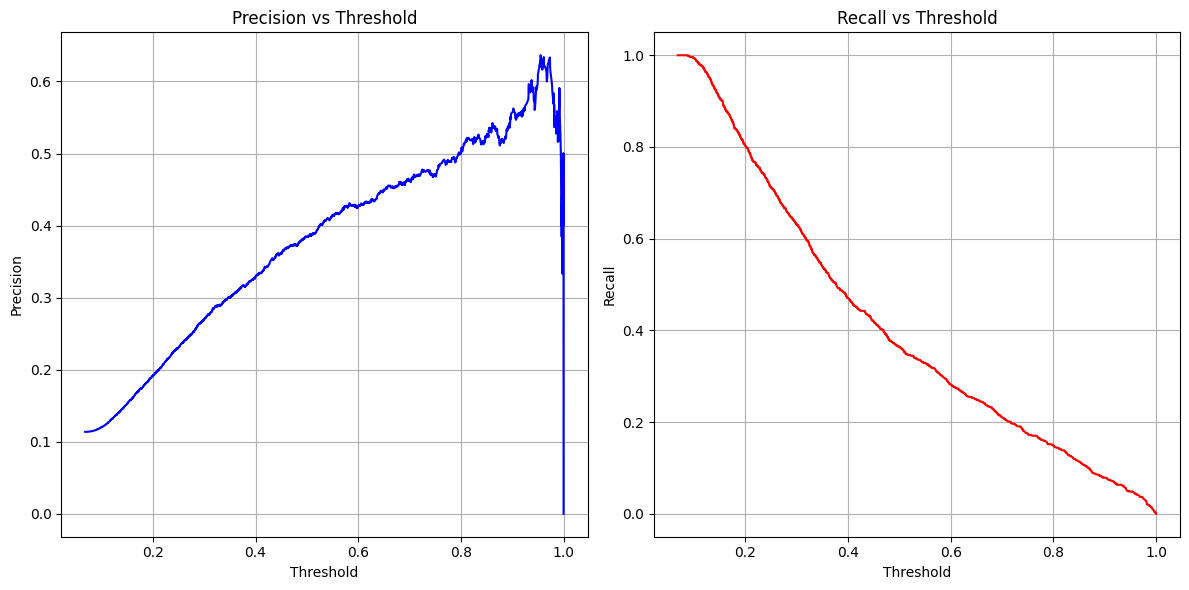

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, recall[:-1], label='Recall', color='r')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()

In [135]:
best_threshold

0.48411446200891567

KFold

In [ ]:
from sklearn.model_selection import KFold

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)

std_error_auc = np.std(auc_scores)

print(f"{std_error_auc:.3f}")

0.005


Тюнинг гиперпараметров

In [ ]:
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    auc_scores = []

    for train_index, val_index in kf.split(X):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    results[C] = {'mean_auc': mean_auc, 'std_auc': std_auc}

for C, metrics in results.items():
    print(f"Для C = {C}:")
    print(f"Среднее AUC: {metrics['mean_auc']:.3f}")
    print(f"Стандартное отклонение AUC: {metrics['std_auc']:.3f}")

best_C = max(results, key=lambda x: results[x]['mean_auc'])
print(f"\nЛучший параметр C: {best_C}")

Для C = 1e-06:
Среднее AUC: 0.704
Стандартное отклонение AUC: 0.011
Для C = 0.001:
Среднее AUC: 0.768
Стандартное отклонение AUC: 0.010
Для C = 1:
Среднее AUC: 0.830
Стандартное отклонение AUC: 0.005

Лучший параметр C: 1


<h1>Ответы</h1>
<h3>
    <ul>
        (1) -- duration<br>
        (2) -- 0.77<br>
        (3) -- 0.48<br>
        (4) -- 0.43<br>
        (5) -- 0.005<br>
        (6) -- 1
    </ul>
</h3>

